In [23]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image
from keras.applications import mobilenet_v2
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
# Constants
DATA_SRC = 'garbage_classification/'
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [15]:
filepaths = []
labels = []

for label in os.listdir(DATA_SRC):
    path = os.path.join(DATA_SRC, label)
    if not os.path.isdir(path) or label.startswith('.'):
        continue
    for file_name in os.listdir(path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(path, file_name))
            labels.append(label)
            
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

print(f"Number of images found: {len(df)}")
print(f"Class distribution: {df['label'].value_counts()}")
df.sample(frac=1)

Number of images found: 15515
Class distribution: label
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64


,filepath,label
8275,garbage_classification/clothes/clothes569.jpg,clothes
1217,garbage_classification/biological/biological34...,biological
10787,garbage_classification/paper/paper626.jpg,paper
12155,garbage_classification/shoes/shoes1079.jpg,shoes
9400,garbage_classification/metal/metal115.jpg,metal
...,...,...
6075,garbage_classification/clothes/clothes3381.jpg,clothes
14195,garbage_classification/trash/trash236.jpg,trash
1348,garbage_classification/biological/biological46...,biological
1390,garbage_classification/biological/biological50...,biological


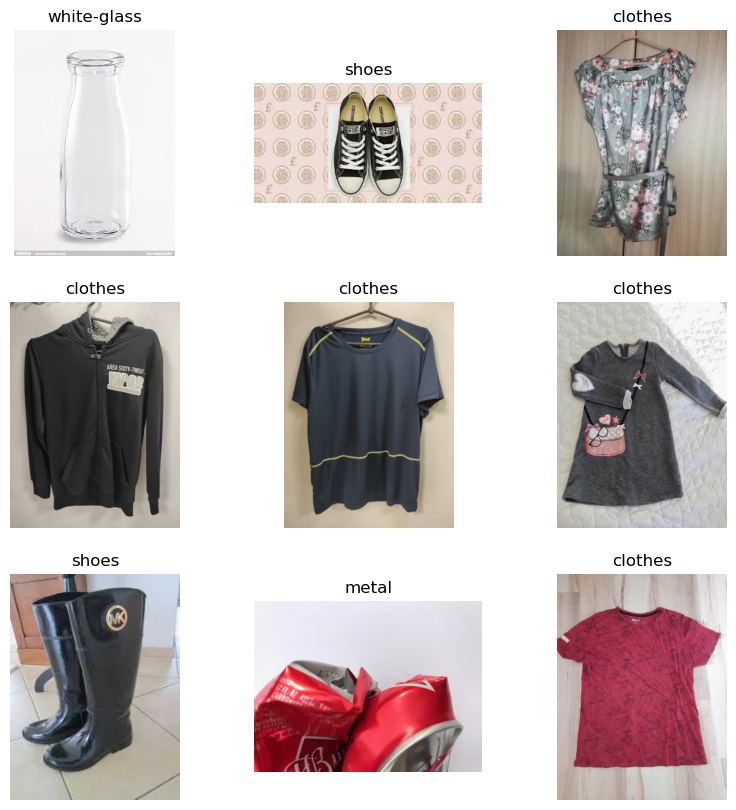

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(df))
    img_path = df.iloc[idx]['filepath']
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(df.iloc[idx]['label'])
    ax.axis('off')

# Model training

In [31]:
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
model.add(mobile_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(df['label'].unique()), activation='softmax'))


model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['categorical_accuracy']
)